<a href="https://colab.research.google.com/github/rubeshajith/NYC-taxi-trip-time-prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# Mounting of Drive, Importing libraries and Loading Data

In [2]:
# Mounting of google drive to feth the csv file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Libraries which are necessary and their importing.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from geopy.distance import great_circle
from scipy.stats import zscore
import warnings; warnings.simplefilter('ignore')

In [4]:
# Fetching the given csv file using pandas
df = pd.read_csv("/content/drive/MyDrive/data/project/NYC Taxi Data.csv")

# Information About The Data

In [5]:
#Total number of Rows and Columns in Dataset     
df.shape

(1458644, 11)

In [6]:
# Top 5 elements in our dataframe
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
# NULL/NAN values in given dataset
df[df.isnull()].sum()

id                      0
vendor_id             0.0
pickup_datetime         0
dropoff_datetime        0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag      0
trip_duration         0.0
dtype: object

Their are no NULL values in the given dataframe

In [8]:
# Number of unique elements in the dataset columns
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [9]:
# Information of the dataset given
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Converting 'pickup_datetime' and 'dropoff_datetime' column's datatype from object to datetime, So that we can use them for creating separate features such as date, month, time and few other variables

In [10]:
# Converting datetime columns which is object type into 'datetime'
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

# Creation of Variables


In [11]:
# Creating the day name with help of datetime package
df["pickup_day"] = df["pickup_datetime"].dt.day_name()
df["dropoff_day"] = df["dropoff_datetime"].dt.day_name()

In [12]:
# Converting those days to numeric form:
df["pickup_day_no"] = df["pickup_day"].map({"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday": 3, "Thursday": 4, "Friday":5, "Saturday":6})
df["dropoff_day_no"] = df["dropoff_day"].map({"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday": 3, "Thursday": 4, "Friday":5, "Saturday":6})

In [13]:
# Creating hour column with the help of pickup and dropoff datetime columns
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["dropoff_hour"] = df["dropoff_datetime"].dt.hour

In [14]:
# Creating month column with our datetime column
df["pickup_month"] = df["pickup_datetime"].dt.month
df["dropoff_month"] = df["dropoff_datetime"].dt.month

In [15]:
# Function to convert time of a day to certain period of the day
def time_of_the_day(x):
  '''Function to extract certain time 
  of the day'''
  if x in range(6,12):
    return "Morning"
  elif x in range(12,16):
    return "Afternoon"
  elif x in range(16,22):
    return "Evening"
  else: 
    return "Night"

In [16]:
# Creating new columns which consists of certain period of a day with help of 'apply' method in pandas
df["pickup_time_of_the_day"] = df["pickup_hour"].apply(time_of_the_day)
df["dropoff_time_of_the_day"] = df["dropoff_hour"].apply(time_of_the_day)

In [17]:
# Importing required package to calculate distances
from geopy.distance import great_circle
def cal_distance(pickup_latitude,pickup_logitude,dropoff_latitude,dropoff_longitude):
  
  '''Calculates distance with help of longitute
  and latitude features and return values of distance
  in kilometer'''
  
  start_coordinates = (pickup_latitude, pickup_logitude)
  stop_coordinates = (dropoff_latitude,dropoff_longitude)
  return great_circle(start_coordinates, stop_coordinates).km

In [18]:
# Creating distance variable in our dataframe
df["distance"] = df.apply(lambda x : cal_distance(x["pickup_latitude"],x["pickup_longitude"],x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)

Using the distance and trip duration we can calculate speed.
Formula for speed is
speed = distance/timetaken

In [19]:
# Creating speed variable using distance and duration variables, speed variable units in km/hr
df['speed'] = (df.distance/(df.trip_duration/3600))

# Univariate Analysis

### Trip Duration

Text(0.5, 1.0, 'Trip Duration')

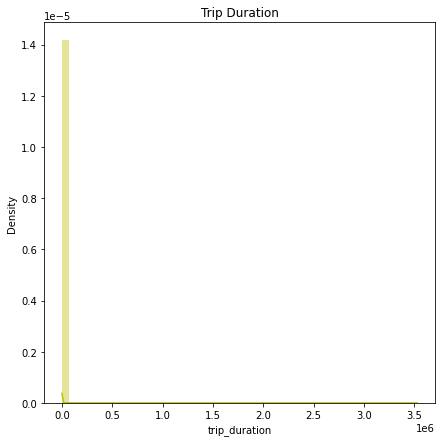

In [20]:
# Plotting our target variable which is 'trip_duration'
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")
plt.title("Trip Duration")


Since the data is positively skewed we can use log-transformation for better vistualization

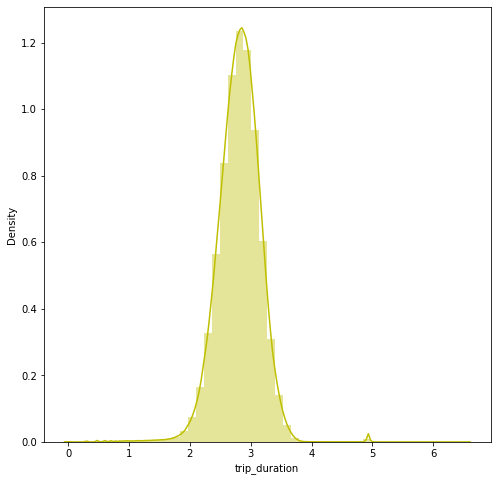

In [21]:
# Scaling all values with log transformation and then plotting them
plt.figure(figsize= (8,8))
sns.distplot(np.log10(df.trip_duration), color="y")

After log transformation we can see that our targer variable is normally distrubuted


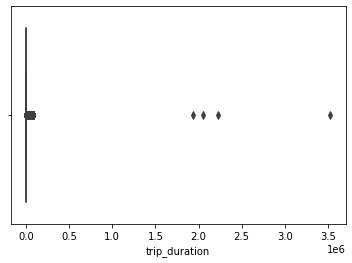

In [22]:
# Plotting boxplot for our target variable
sns.boxplot(df.trip_duration)

We can see few big outliers is our target variable


In [23]:
trip_duration_outliers = df['trip_duration'].sort_values(ascending= False).reset_index()
trip_duration_outliers[:4]

,index,trip_duration
0,978383,3526282
1,924150,2227612
2,680594,2049578
3,355003,1939736


This 4 data points were the biggest outliers out of others, which we were able to detected in boxplot

Here there are trips with more than 24hrs duration which is 86400 seconds, upto 40 days we can detect in trip_duration time which are clearly outliers. We need to remove them for better results in our prediction models

In [24]:
# For better view of our dataset 
pd.set_option("display.max_rows", 200)
pd.set_option("display.min_rows", 50)


In [25]:
# To observe the count of the trip duration with certain range we chose (1-3601) around one hour
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1, max(df.trip_duration)+3600,3600))).count()


trip_duration
(1, 3601]             1446313
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
(18001, 21601]             11
(21601, 25201]             11
(25201, 28801]             13
(28801, 32401]             17
(32401, 36001]              8
(36001, 39601]             13
(39601, 43201]              6
(43201, 46801]              8
(46801, 50401]              5
(50401, 54001]              7
(54001, 57601]              5
(57601, 61201]             10
(61201, 64801]             10
(64801, 68401]             10
(68401, 72001]              5
(72001, 75601]             10
(75601, 79201]             17
(79201, 82801]             63
(82801, 86401]           1839
(86401, 90001]              0
                       ...   
(3438001, 3441601]          0
(3441601, 3445201]          0
(3445201, 3448801]          0
(3448801, 3452401]          0
(3452401, 3456001]          0
(3456001, 3459601]          0
(3459601, 3463201]        

Most of the data fall in the 1st bucket which is within an hour trip

In [26]:
# The shape of data where our trip_duration has crossed one and a half hour (5400sec) 
df[df.trip_duration > 5400].shape

(3097, 23)

In [27]:
df.shape

(1458644, 23)

In [28]:
# Data with less than an one min trip
df[df.trip_duration < 60].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_time_of_the_day,dropoff_time_of_the_day,distance,speed
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,...,6,6,21,21,2,2,Evening,Evening,0.328333,20.736824
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,...,1,1,11,11,6,6,Morning,Morning,0.003927,0.353456
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,...,6,6,12,12,5,5,Afternoon,Afternoon,0.002121,2.545053
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,...,2,2,22,22,3,3,Night,Night,0.383931,23.830173
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,...,4,4,13,13,6,6,Afternoon,Afternoon,0.703066,1265.518471


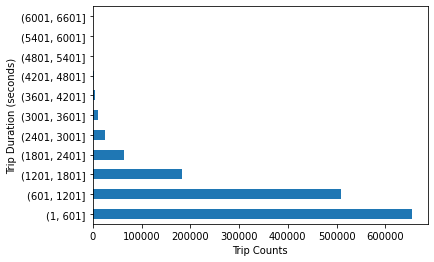

In [29]:
# Plot to compare time_duration of ten minutes bucket with Trip counts
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

From the above plot we can see that within 10mins aprox to 7lakhs trips have been completed and also most of the trip duration is within half an hour i.e, 30 mins(1800 seconds). Also there are very less trips that have duration more than 1800 seconds 

In [30]:
# Now to remove outliers i.e, trips with duration more than 86400 seconds.
df = df[df.trip_duration <= 5400]
# df = df[df.trip_duration >= 60]

### distance

In [31]:
# describe method for statistical analysis
df.distance.describe()

count    1.455547e+06
mean     3.429168e+00
std      4.263229e+00
min      0.000000e+00
25%      1.231343e+00
50%      2.091930e+00
75%      3.868487e+00
max      1.240910e+03
Name: distance, dtype: float64

We can see distance with 0km from the above 

In [32]:
# how much distances are of 0km
print("Total number of trips with 0 distance are {}".format(df.distance[df["distance"] == 0].count()))

Total number of trips with 0 distance are 5893


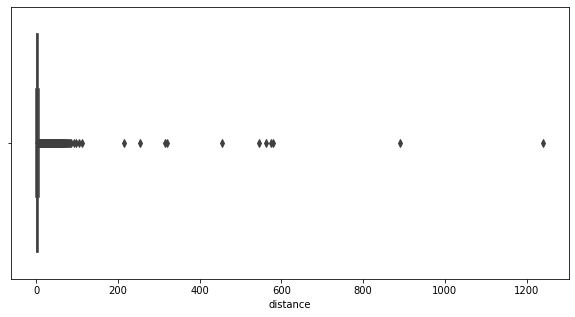

In [33]:
# Plotting boxplot for distance variable
plt.figure(figsize = (10,5))
sns.boxplot(df.distance)
plt.show()

There are some trips with over 100 km distance.

Some of the trips distance value is 0 km.

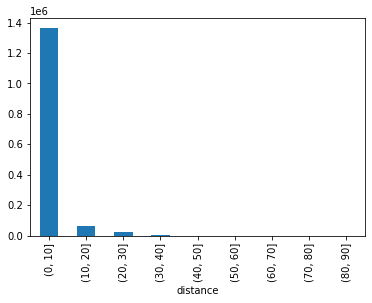

In [34]:
# Creating buckets of 10km distance
df.distance.groupby(pd.cut(df.distance, np.arange(0,100,10))).count().plot(kind= "bar")

From the above graph we can say that most of the trips are covered within 1-10 km , and few from 10-30 km. 

We are not removing 0 km distances, Assuming there might be technical error in gps system

### vendor id

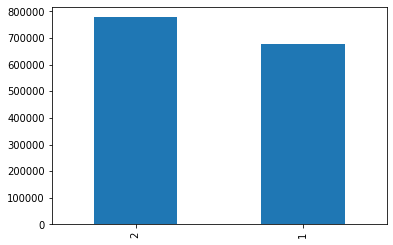

In [35]:
df["vendor_id"].value_counts().plot(kind="bar")

Vendor_id number 2 has committed more trips than vendor_id number 1

### Passenger Count

In [36]:
# Value counts of passenger_count feature
df['passenger_count'].value_counts()

1    1031605
2     209827
5      77832
3      59726
6      48171
4      28322
0         59
7          3
9          1
8          1
Name: passenger_count, dtype: int64

We can see passenger_count of 0 is less so we add it to highest passenger_count bucket which is 1

In [37]:
# We are assigning zero value of passenger count to bucket 1 using map method
df["passenger_count"] = df['passenger_count'].map(lambda x: 1 if x == 0 else x)

In [38]:
df.shape

(1455547, 23)

In [39]:
# omitting number of passenger above 6
df = df[df["passenger_count"] <= 6]

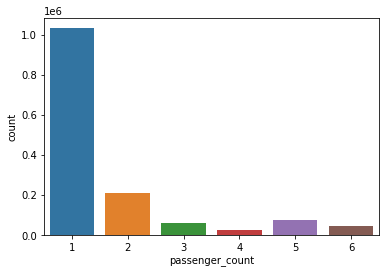

In [40]:
# Plotting passenger_count vs their counts
sns.countplot(x="passenger_count", data= df)

### Store and forward flag

In [41]:
df['store_and_fwd_flag'].value_counts()

N    1447523
Y       8019
Name: store_and_fwd_flag, dtype: int64

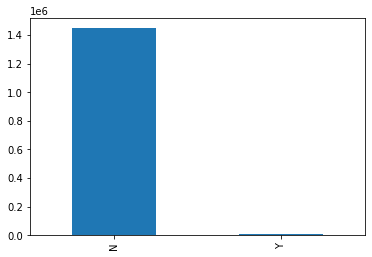

In [42]:
# Countplot for Store and Forward Flag
df['store_and_fwd_flag'].value_counts().plot(kind= "bar")

From Store and Forward Flag, we can see many of the data is not connected to server

In [43]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_time_of_the_day,dropoff_time_of_the_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1,1,17,17,3,3,Evening,Evening,1.498523,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,6,6,Night,Night,1.805510,9.803673
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2,2,11,12,1,1,Morning,Afternoon,6.385108,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,3,3,19,19,4,4,Evening,Evening,1.485501,12.465739
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6,6,13,13,3,3,Afternoon,Afternoon,1.188590,9.836608


### Speed

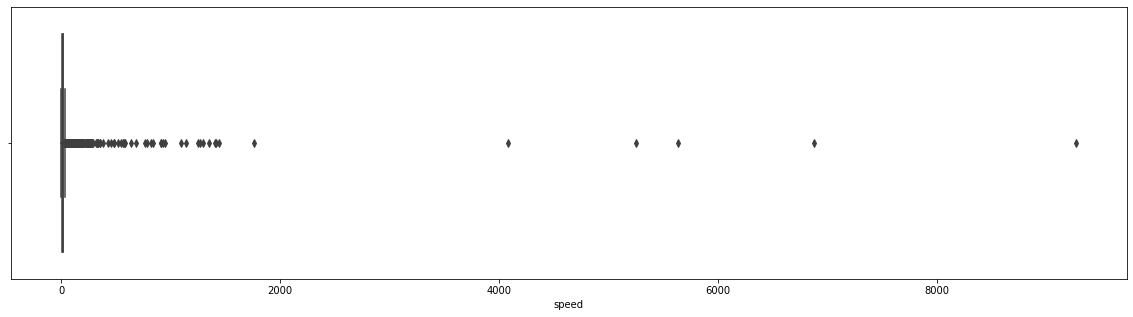

In [44]:
# Box plot for speed to check outliers
plt.figure(figsize = (20,5))
sns.boxplot(df.speed)
plt.show()

In NYC the maximum speed limit 40 km/hr in urban areas and 104 km/hr on highways.

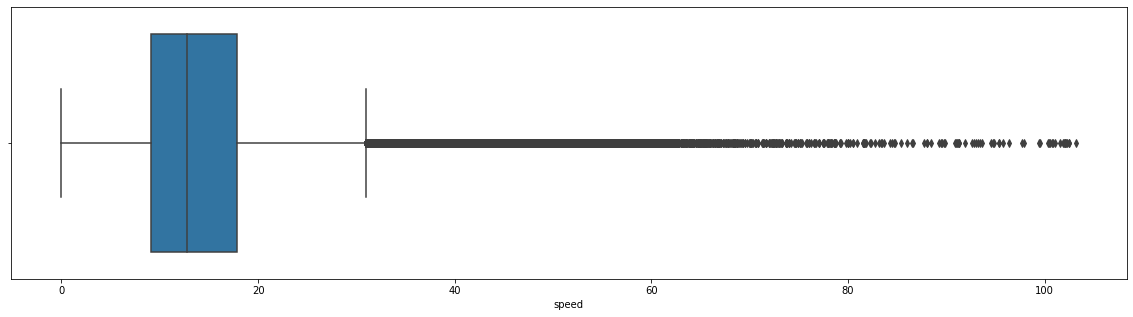

In [45]:
# Selecting data where speed is less than or equal to 104 km/hr and plotting again
df = df[df['speed'] <= 104] 
plt.figure(figsize = (20,5))
sns.boxplot(df.speed) 
plt.show()

Text(0.5, 1.0, 'Dropoff_days vs Count')

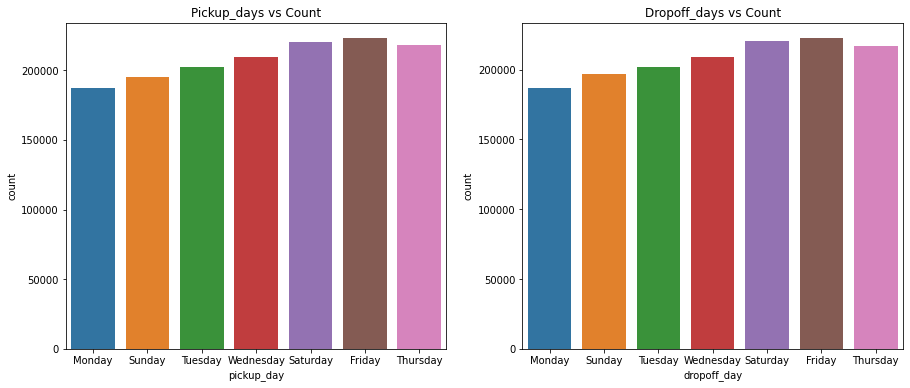

In [46]:
# plotting both pickup and dropoff days
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_day", data=df)
fig.set_title("Pickup_days vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_day", data= df)
fig.set_title("Dropoff_days vs Count")

Saturday and Friday are busiest than compared to weekdays

Text(0.5, 1.0, 'Dropoff_hour vs Count')

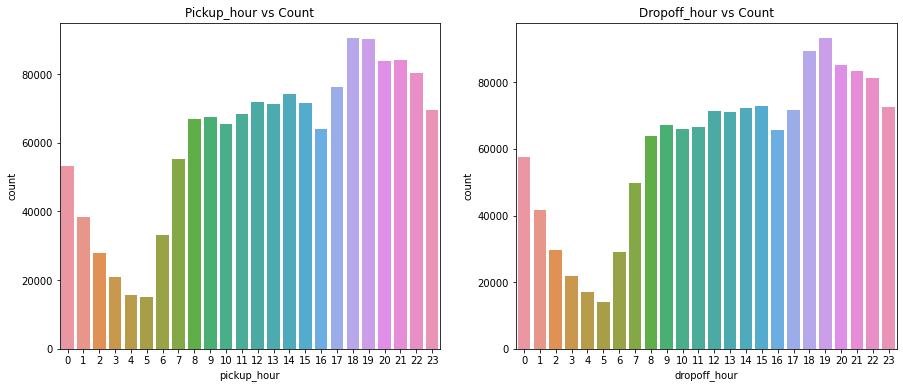

In [47]:
# plot for pickup and dropoff hours
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_hour", data=df)
fig.set_title("Pickup_hour vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_hour", data= df)
fig.set_title("Dropoff_hour vs Count")

Busy in peak hours which is from 6pm to 7pm

Text(0.5, 1.0, 'Dropoff_time_of_the_day vs Count')

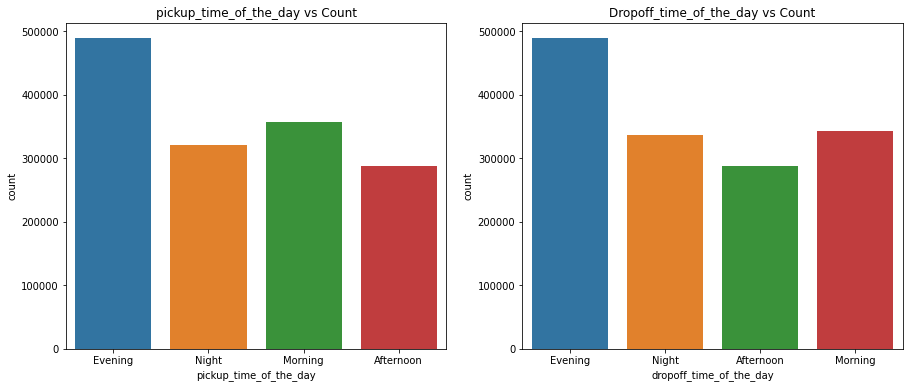

In [48]:
# plot for both pickup and dropoff period of time
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_time_of_the_day", data=df)
fig.set_title("pickup_time_of_the_day vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_time_of_the_day", data= df)
fig.set_title("Dropoff_time_of_the_day vs Count")

Evening and morning are busiest compared to others

Text(0.5, 1.0, 'Dropoff_monthy vs Count')

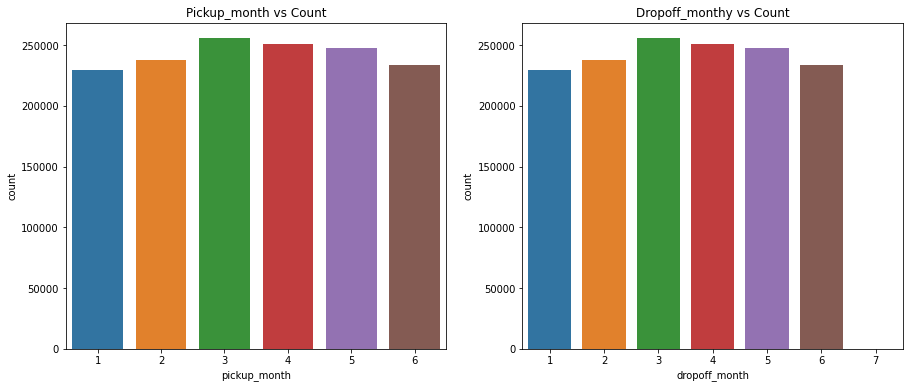

In [49]:
# plot for pickup and dropoff months
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_month", data=df)
fig.set_title("Pickup_month vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_month", data= df)
fig.set_title("Dropoff_monthy vs Count")


Data consists of half year maybe, we see similar usage in months, March stands a bit higher rate compared to others

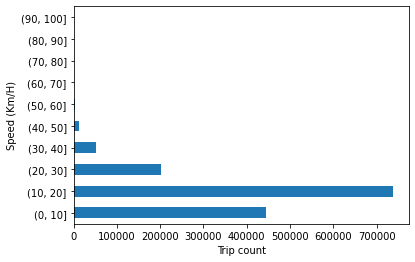

In [50]:
# plotting in group with respect to count
df.speed.groupby(pd.cut(df.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

Most of the trips are done under 0-20 km/hr and above 40 km/hr are all outliers but still they are under the 104 km/hr which is the maximum speed limit.

# Bivariate analysis

### trip duration per vendor

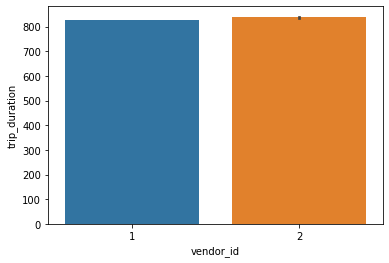

In [51]:
sns.barplot(x= "vendor_id", y="trip_duration",data=df)

We can observe vendor_id number 2 has done longer trips compared to vendor 1

### trip duration per store and forward flag

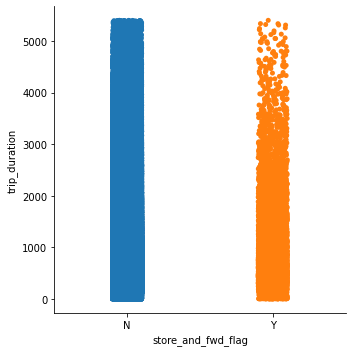

In [52]:
# plotting using catplot since bar plot was'nt able to capture those less scattered data points
sns.catplot(x="store_and_fwd_flag",y="trip_duration",data=df, kind="strip")

Trip duration is generally longer for trips whose flag was not stored

### Trip duration per passenger count

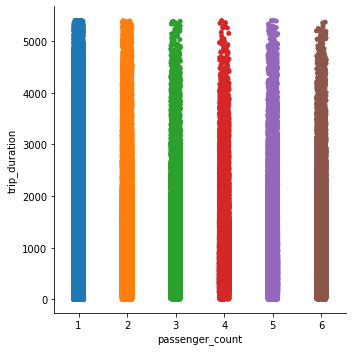

In [53]:
# plot for trip_duration vs passenger count
sns.catplot(x="passenger_count",y="trip_duration",data=df, kind="strip")

No valid relationship with trip_duration and passenger count

###Trip Duration per hour 

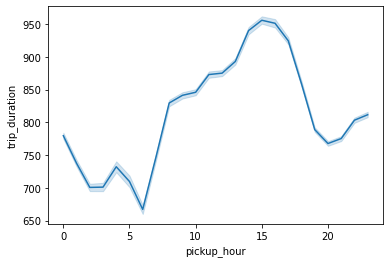

In [54]:
# plotting lineplot for Trip Duration vs hour 
sns.lineplot(x="pickup_hour", y="trip_duration", data=df)

We can observe that trip duration is maximum at 3pm which might be because of traffic issues, and trip duration in morning 6am is low because of less traffic

In [55]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_time_of_the_day', 'dropoff_time_of_the_day',
       'distance', 'speed'],
      dtype='object')

### Trip_duration per period of time in a day

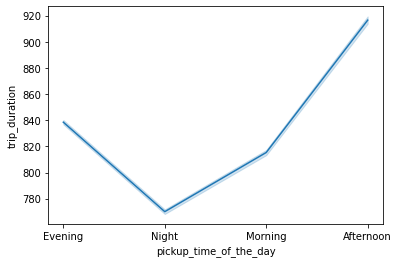

In [56]:
# plotting lineplot for Trip_duration vs time of the day
sns.lineplot(x="pickup_time_of_the_day", y='trip_duration', data=df)

Trip duration is lowest in morning time , lower in night and evening as compared to afternoon

### Trip Duration per Day of the Week

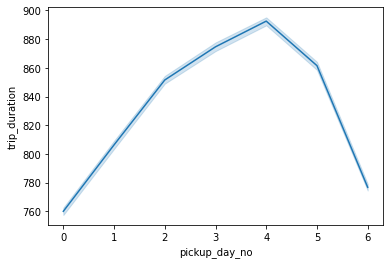

In [57]:
# Plotting lineplot for Trip_duration per day of the week
sns.lineplot(x="pickup_day_no", y='trip_duration', data=df)



Trip duration is longest on Thursday and bit lower on Friday

### Trip Duration per Month

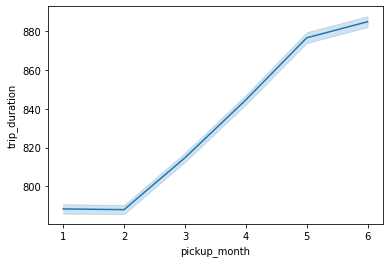

In [58]:
# plotting lineplot for trip_duration vs month
sns.lineplot(x="pickup_month", y='trip_duration', data=df)


From February, we see trip_duration is gradually rising every month

### Distance vs Trip Duration

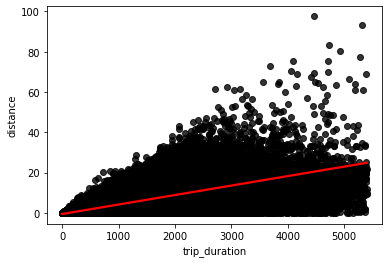

In [59]:
sns.regplot(x= "trip_duration", y="distance", data=df,scatter_kws={"color":"black"}, line_kws={"color":"red"})

We can clearly tell that trips with distance as short as 0 seconds and yet covering a large trip_duration

It seems like there is some linear relationship btw distance and trip_duration, yet there is no homoscedasticity (same variance) which breaks the assumption of linear regression

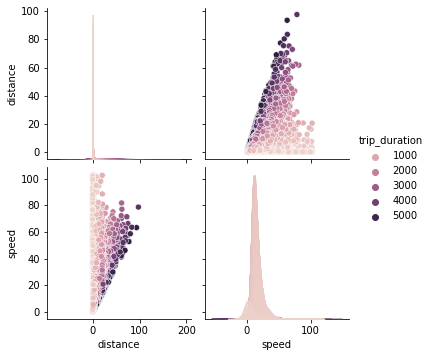

In [60]:
sns.pairplot(df,vars=["distance","speed"], hue= "trip_duration")

We can observe some data with speed 0km/hr and distance ranging from 0 to aprox of 60km which has a trip duration around 75000 seconds(almost 21 hrs)

The diagonal plots are variable plot to itself (ie,distance vs distance and speed vs speed), left bottom plot is speed vs distance plot and data points scattered within are respect to trip_duration, similarly the other plot. Most of the trip duration is covered below 15000 seconds (almost 4hrs 20mins)

From the above regplot and pairplot we can clearly see distances with 0 has more trip duration

Let's remove distance with 0km and trip_duration above 60sec

Assuming that people who might have canceled after booking would'nt have taken more than a minute in duration

In [61]:
# Removing data as per our assumption 
df = df[~((df.distance ==0) & (df.trip_duration >=60))]
df[df["distance"] ==0][["distance","trip_duration"]]


,distance,trip_duration
1620,0.0,27
1728,0.0,19
2441,0.0,8
2625,0.0,6
3042,0.0,6
3261,0.0,7
4158,0.0,17
4892,0.0,5
7794,0.0,15
8618,0.0,10


In [62]:
df = df[~((df.distance <=1) & (df.trip_duration >=1800))]
df[df["distance"] <=1][["distance","trip_duration"]]

,distance,trip_duration
13,0.991686,260
15,0.656579,211
37,0.959437,277
68,0.624613,215
72,0.328333,57
83,0.916534,218
84,0.790333,222
88,0.905890,336
101,0.921062,593
108,0.983684,243


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450286 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1450286 non-null  object        
 1   vendor_id                1450286 non-null  int64         
 2   pickup_datetime          1450286 non-null  datetime64[ns]
 3   dropoff_datetime         1450286 non-null  datetime64[ns]
 4   passenger_count          1450286 non-null  int64         
 5   pickup_longitude         1450286 non-null  float64       
 6   pickup_latitude          1450286 non-null  float64       
 7   dropoff_longitude        1450286 non-null  float64       
 8   dropoff_latitude         1450286 non-null  float64       
 9   store_and_fwd_flag       1450286 non-null  object        
 10  trip_duration            1450286 non-null  int64         
 11  pickup_day               1450286 non-null  object        
 12  

In [64]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_time_of_the_day', 'dropoff_time_of_the_day',
       'distance', 'speed'],
      dtype='object')

In [65]:
dataset_pre = df.copy()

In [66]:
pd.set_option("display.max_columns", 50)

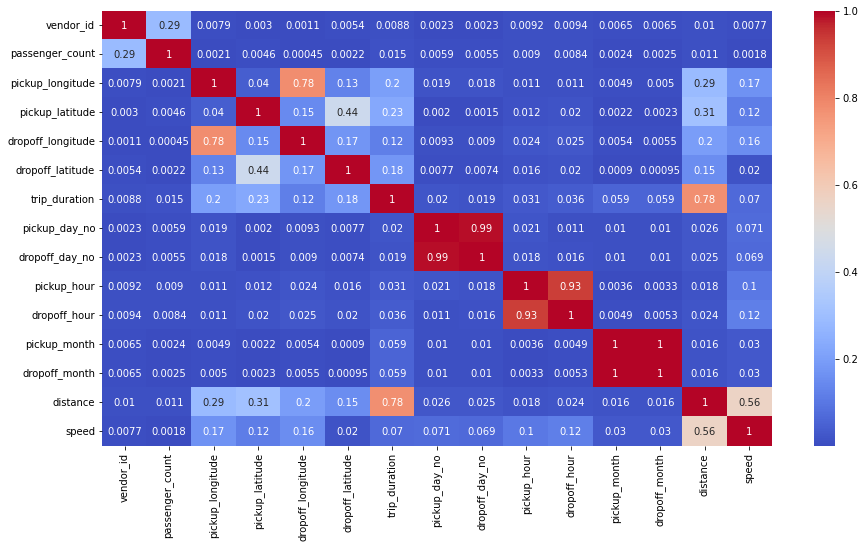

In [67]:
# plotting heatmap for checking multicollinarity
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Since there is more correlation between variables which is not likely for our linear regression model to predict, as it assumes to have less multicollinarity. We'll only take pickup data for month, hour, weekday_number and also lets drop speed (km/hr) because it is correlated with distance(km)

### One Hot Encoding

In [68]:
#label encoding
dataset_pre["store_and_fwd_flag_num"] = dataset_pre["store_and_fwd_flag"].map({"N": 0, "Y" : 1})
dataset_pre["vendor_id_onehot"] = dataset_pre["vendor_id"].map({2: 1, 1 : 0})

In [69]:
# One hot encoding
dataset_pre = pd.get_dummies(dataset_pre, columns=["pickup_day_no","pickup_month","pickup_time_of_the_day"],
                             prefix=["weekday_num","month_no","pickup"])

In [70]:
dataset_pre.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,dropoff_day_no,pickup_hour,dropoff_hour,dropoff_month,dropoff_time_of_the_day,distance,speed,store_and_fwd_flag_num,vendor_id_onehot,weekday_num_0,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,month_no_1,month_no_2,month_no_3,month_no_4,month_no_5,month_no_6,pickup_Afternoon,pickup_Evening,pickup_Morning,pickup_Night
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,1,17,17,3,Evening,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,0,0,0,6,Night,1.805510,9.803673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,2,11,12,1,Afternoon,6.385108,10.822216,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,3,19,19,4,Evening,1.485501,12.465739,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,6,13,13,3,Afternoon,1.188590,9.836608,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [71]:
dataset_pre.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'dropoff_month',
       'dropoff_time_of_the_day', 'distance', 'speed',
       'store_and_fwd_flag_num', 'vendor_id_onehot', 'weekday_num_0',
       'weekday_num_1', 'weekday_num_2', 'weekday_num_3', 'weekday_num_4',
       'weekday_num_5', 'weekday_num_6', 'month_no_1', 'month_no_2',
       'month_no_3', 'month_no_4', 'month_no_5', 'month_no_6',
       'pickup_Afternoon', 'pickup_Evening', 'pickup_Morning', 'pickup_Night'],
      dtype='object')

In [72]:
# Removing most correlated variables 
dataset_pre = dataset_pre.drop(["id","vendor_id","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_day","dropoff_day"
,"dropoff_day_no","dropoff_hour","dropoff_month","dropoff_time_of_the_day"],axis= 1)


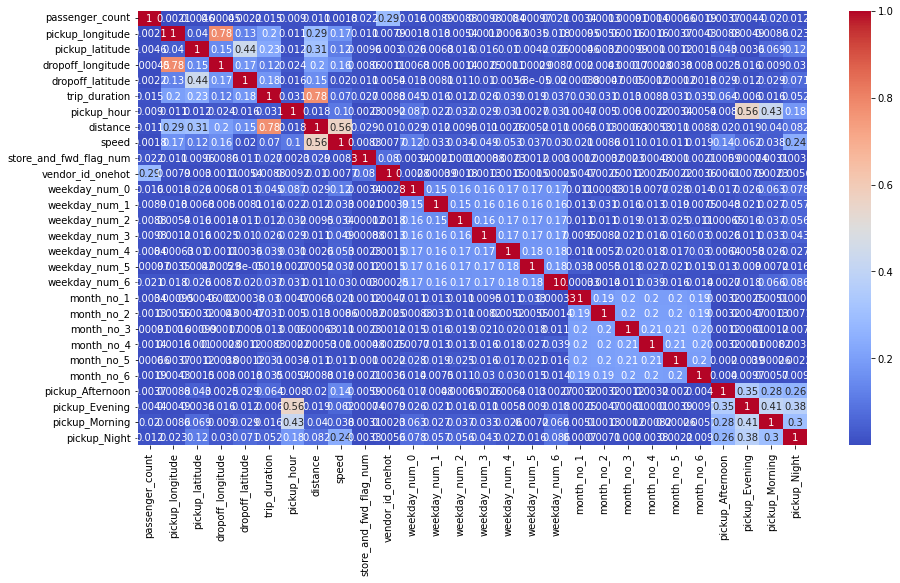

In [73]:
# plotting Heatmap after creating dummies and removing most correlated features
plt.figure(figsize=(15,8))
correlation = dataset_pre.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Now it looks better than before, but still dropoff longitute and pickup longitute have 0.72 correlation, lets let it be its our coordinates of loaction so

# Rescaling and Splitting Our Data For Training And Testing

### Creating X and Y for our Linear Model

In [74]:
# Splitting Features (X and Y),  Rescaling inputs
from scipy.stats import zscore # Scaling our data with zscore 
X = dataset_pre[[i for i in dataset_pre.describe().columns if i not in ['trip_duration']]].apply(zscore)  # Standarization
y = dataset_pre["trip_duration"] 

### Splitting data for traning and testing for model prediction 

In [75]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 

In [76]:
print(X_train.shape)
print(X_test.shape)

(1160228, 27)
(290058, 27)


# Multiple Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [78]:
reg.score(X_test, y_test)

0.8048285253497541

Linear regression score is nothing but the R2 score by default, score of 0.8048 means that 80.48% of variance in independent variable(y) is predictable from dependent variable(X)

In business decisions, the benchmark for the R2 score value is 0.7. It means if R2 score value >= 0.7, then the model is good enough to deploy on unseen data whereas if R2 score value < 0.7, then the model is not good enough to deploy. Our R2 score value has been found to be .8048. It means that this model explains 80.48 % of the variance in our dependent variable. So, the R2 score value confirms that the model is good enough to deploy because it does provide good fit to the data.

In [79]:
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [80]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(y_test, y_test_pred)
print("MSE for test split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE for test split :" ,RMSE)

r2 = r2_score(y_test, y_test_pred)
print("R2 for test split :" ,r2)

n_test = X_test.shape[0]
k_test = X_test.shape[1]
print("Adjusted R2 for test split : ",1-(1-r2)*((n_test-1)/(n_test- k_test -1)))

RSS = sum((y_test - y_test_pred)**2)
print("Residual Sum Square : ",RSS)

MSE for test split : 80119.30987892838
RMSE for test split : 283.05354595717114
R2 for test split : 0.8048285253497541
Adjusted R2 for test split :  0.8048103560920374
Residual Sum Square :  23239246784.862247


In [81]:
MSE  = mean_squared_error((y_train), (y_train_pred))
print("MSE for train split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE for train split :" ,RMSE)

r2 = r2_score(y_train, y_train_pred)
print("R2 for train split :" ,r2)

n_train = X_train.shape[0]
k_train = X_train.shape[1]
print("Adjusted R2 for train split : ",1-(1-r2)*((n_train-1)/(n_train- k_train -1)))

RSS = sum((y_train - y_train_pred)**2)
print("Residual Sum Square for train split : ",RSS)

MSE for train split : 80076.72969192718
RMSE for train split : 282.97832018005755
R2 for train split : 0.805454164887495
Adjusted R2 for train split :  0.8054496374460642
Residual Sum Square for train split :  92907263937.00581


In [82]:
reg.coef_

array([ 1.54868829e+00, -1.97334689e+01,  3.64431798e+01,  6.09213888e+00,
       -1.37601461e+01, -4.57691594e+00,  7.04821105e+02, -3.43093122e+02,
        3.75158427e-01,  7.21011649e-01,  1.46741883e+11,  1.44200452e+11,
        1.49038382e+11,  1.51275568e+11,  1.53761540e+11,  1.55163155e+11,
        1.54448004e+11,  4.92896286e+12,  5.00391836e+12,  5.15007503e+12,
        5.11347447e+12,  5.08658922e+12,  4.96739883e+12,  1.32606648e+12,
        1.57097535e+12,  1.43076700e+12,  1.37944133e+12])

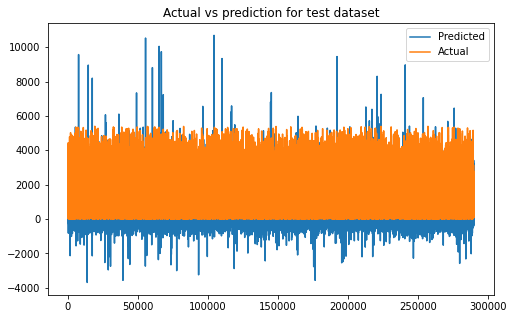

In [83]:
plt.figure(figsize=(8,5))
plt.plot(y_test_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.title("Actual vs prediction for test dataset")
plt.show()

### Checking for Overfitting and Underfitting

In [84]:
print("Training set score: {:.4f}".format(reg.score(X_train, y_train)))
print("Testing set score: {:.4f}".format(reg.score(X_test, y_test)))

RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE for train split :" ,RMSE)

RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE for test split :" ,RMSE)

Training set score: 0.8055
Testing set score: 0.8048
RMSE for train split : 282.97832018005755
RMSE for test split : 283.05354595717114


Our model is having a training score of 0.8055 and testing score of 0.8048 which is clearly a good score ,our model does'nt have greater fluctuation of RMSE between train and test split , our model is neither underfitting nor overfitting because training eror is slightly lower than testing error, So we guess we have an optimal model 

As per our theortical knowledge we know that R2 should be close to 1, RMSE or error metric towards zero (assuming no noise)

In [85]:
reg.coef_

array([ 1.54868829e+00, -1.97334689e+01,  3.64431798e+01,  6.09213888e+00,
       -1.37601461e+01, -4.57691594e+00,  7.04821105e+02, -3.43093122e+02,
        3.75158427e-01,  7.21011649e-01,  1.46741883e+11,  1.44200452e+11,
        1.49038382e+11,  1.51275568e+11,  1.53761540e+11,  1.55163155e+11,
        1.54448004e+11,  4.92896286e+12,  5.00391836e+12,  5.15007503e+12,
        5.11347447e+12,  5.08658922e+12,  4.96739883e+12,  1.32606648e+12,
        1.57097535e+12,  1.43076700e+12,  1.37944133e+12])

Since our linear model coefficients have more larger values its a sign that our model may be overfitting the data. The larger the absolute value of the coefficient, the more power it has to change the predicted response, resulting in a higher variance.

So we implement regularization to shrink the coefficients and also the size of coeffficient. It gives more weightage to important features so that our present same model will do better prediction on future/unseen/extented data of this problem.

We'll do both LASSO (least absolute shrinkage and selection operation) and Ridge regression. Lasso to find out which features are important accordingly, Ridge for shrinking coef_ towards zero not exactly zero and we can clearly say that every feature is important for trip_duration prediction expect corrdinates in our data, so its best to use Ridge if we had to pick one.

# LASSO Regression 

In [86]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


In [87]:
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=3)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 10]},
             scoring='r2')

In [88]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 10}

Using  {'alpha': 10}  the negative mean squared error is:  0.8015168026806957


In [89]:
lasso_reg = Lasso(alpha=10, fit_intercept=True)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=10)

In [90]:
y_test_lasso_pred = lasso_reg.predict(X_test)
y_train_lasso_pred = lasso_reg.predict(X_train)

In [91]:
MSE  = mean_squared_error(y_test, y_test_lasso_pred)
print("MSE of lasso for test split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE of lasso for test split :" ,RMSE)

r2 = r2_score(y_test, y_test_lasso_pred)
print("R2 of lasso for test split :" ,r2)

n_test = X_test.shape[0]
k_test = X_test.shape[1]
print("Adjusted R2 of lasso for test split : ",1-(1-r2)*((n_test-1)/(n_test- k_test -1)))

RSS = sum((y_test - y_test_lasso_pred)**2)
print("Residual Sum Square of lasso for test split : ",RSS)

MSE of lasso for test split : 81810.67881746964
RMSE of lasso for test split : 286.02566111709217
R2 of lasso for test split : 0.8007083329715178
Adjusted R2 of lasso for test split :  0.8006897801493622
Residual Sum Square of lasso for test split :  23729841876.43799


In [92]:
MSE  = mean_squared_error(y_train, y_train_lasso_pred)
print("MSE of lasso for train split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE of lasso for train split :" ,RMSE)

r2 = r2_score(y_train, y_train_lasso_pred)
print("R2 of lasso for train split :" ,r2)

n_train = X_train.shape[0]
k_train = X_train.shape[1]
print("Adjusted R2 of lasso for train split : ",1-(1-r2)*((n_train-1)/(n_train- k_train -1)))

RSS = sum((y_train - y_train_lasso_pred)**2)
print("Residual Sum Square of lasso for train split : ",RSS)

MSE of lasso for train split : 81699.14614215089
RMSE of lasso for train split : 285.83062491998805
R2 of lasso for train split : 0.8015125158663206
Adjusted R2 of lasso for train split :  0.8015078966954262
Residual Sum Square of lasso for train split :  94789636930.21877


In [129]:
81699.14614215089 - 81810.67881746964

-111.53267531875463

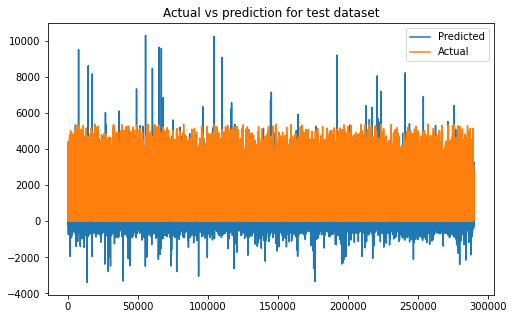

In [93]:
plt.figure(figsize=(8,5))
plt.plot(y_test_lasso_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.title("Actual vs prediction for test dataset")
plt.show()

In [94]:
print(lasso_reg.sparse_coef_)

  (0, 1)	-2.0472732707508503
  (0, 2)	14.45354689639799
  (0, 6)	675.8475490212373
  (0, 7)	-325.30874309397353
  (0, 10)	-0.13420242338262922
  (0, 22)	0.4725633797756498


We can interpret that only 6 features have been selected by L1 regularization i.e, pickup_longitude, pickup_latitude, distance, speed,weekday_num_0 (Sunday), month_no_6 (June) with their corresponding coefficients above, three features are positively influncing (pickup_longitude, distance month_no6 features) other three are negatively impacting and the other features have been totally shrunk to zero

All our coef_ values have been shrunk unlike linear regression which had large values about 12 digits.

# Ridge Regression

In [95]:
from sklearn.linear_model import Ridge

# Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [96]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 100}

Using  {'alpha': 100}  the negative mean squared error is:  0.7946560335829302


In [97]:
# The best fit alpha value is found out to be : {'alpha': 100}
# Using  {'alpha': 100}  the negative mean squared error is:  0.7946560335829281

In [98]:
ridge_reg = Ridge(alpha=100,fit_intercept=True )
ridge_reg.fit(X_train, y_train)

Ridge(alpha=100)

In [99]:
y_test_ridge_pred = ridge_reg.predict(X_test)
y_train_ridge_pred = ridge_reg.predict(X_train)

In [100]:
MSE  = mean_squared_error(y_test, y_test_ridge_pred)
print("MSE of ridge for test split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE of ridge for test split :" ,RMSE)

r2 = r2_score(y_test, y_test_ridge_pred)
print("R2 of ridge for test split :" ,r2)

n_test = X_test.shape[0]
k_test = X_test.shape[1]
print("Adjusted R2 of ridge for test split : ",1-(1-r2)*((n_test-1)/(n_test- k_test -1)))

RSS = sum((y_test - y_test_ridge_pred)**2)
print("Residual Sum Square of ridge for test split : ",RSS)

MSE of ridge for test split : 80119.70997510554
RMSE of ridge for test split : 283.05425270627103
R2 of ridge for test split : 0.8048275507112929
Adjusted R2 of ridge for test split :  0.8048093813628434
Residual Sum Square of ridge for test split :  23239362835.959286


In [101]:
MSE  = mean_squared_error(y_train, y_train_ridge_pred)
print("MSE of ridge for train split :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE of ridge for train split :" ,RMSE)

r2 = r2_score(y_train, y_train_ridge_pred)
print("R2 of ridge for train split :" ,r2)

n_train = X_train.shape[0]
k_train = X_train.shape[1]
print("Adjusted R2 of ridge for train split : ",1-(1-r2)*((n_train-1)/(n_train- k_train -1)))

RSS = sum((y_train - y_train_ridge_pred)**2)
print("Residual Sum Square of ridge for train split : ",RSS)

MSE of ridge for train split : 80076.73919011021
RMSE of ridge for train split : 282.9783369625848
R2 of ridge for train split : 0.805454141811728
Adjusted R2 of ridge for train split :  0.8054496143697603
Residual Sum Square of ridge for train split :  92907274957.0585


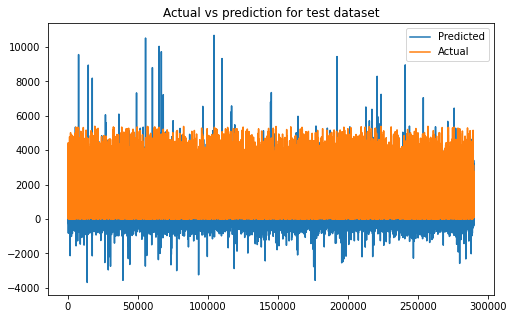

In [102]:
plt.figure(figsize=(8,5))
plt.plot(y_test_ridge_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.title("Actual vs prediction for test dataset")
plt.show()

In [103]:
ridge_reg.coef_

array([ 1.54861403e+00, -1.97022838e+01,  3.64133701e+01,  6.08195619e+00,
       -1.37733221e+01, -4.57013343e+00,  7.04682564e+02, -3.42984629e+02,
        3.77132028e-01,  7.21098138e-01, -7.58571310e+00, -6.59413187e+00,
        1.63607970e+00,  6.35319145e+00,  7.07330113e+00,  2.72453071e+00,
       -4.21663694e+00, -6.46953938e+00, -6.84244383e+00, -3.90415476e+00,
        2.08449920e+00,  7.12398673e+00,  7.91923770e+00,  5.66037926e+00,
       -8.83915491e-01, -2.35459730e-01, -4.19049483e+00])

As per our requirement all our features coef_ are'nt shrunk to zero, we can see all our features have been modified before in linear regression we had larger value for coef_(about 12 digits). L2 regularization is best as per our model requirement (assuming all features are important).

Also if we observe metrics part, we can see MSE, RMSE, RSS are less compared to L1 regularization and R2 score is slightly increased in Ridge regularization

# Random Forest Regresssor

Since major disadvantage of Decision Tree is it overfits, we can deploy 3 methods to avoid it,
1.   Using hyper parameters
2.   Pruning technique
3.   Ensembles 



We're directly using Ensembles models of Bagging and Boosting concept namely Random Forest, XGboost. We're avoiding Decision Tree because it's computationally time consuming running all models

Since Bagging concept helps to reduce variance error and Boosting concept helps to reduces bias error, we're good enough with this two concept base models
 

Random forest is extention of bagging concept in which trees are not fixed with their features, features are randomly chosen in Random forest, and also have an advantage that every feature gets a chance to fit in.

### Creating a separate dataset for tree model

Since tree models are Non-parametric (No assumptions), we're keeping all the columns which were correlated, we're not doing one hot encoding for numeric columns, we're just converting categorical columns to one hot encoding others columns are left as it is.

In [104]:
# Creating df for ensembles without dropping correlated columns
df_ensembles = df.copy()

In [105]:
df_ensembles.shape

(1450286, 23)

In [106]:
# One hot encoding for categorical variables
df_ensembles["store_and_fwd_flag_num"] = df_ensembles["store_and_fwd_flag"].map({"N": 0, "Y" : 1})
df_ensembles["pickup_time_of_the_day_num"] = df_ensembles["pickup_time_of_the_day"].map({"Morning": 0, "Afternoon" : 1, "Evening" : 2,"Night":3})
df_ensembles["dropoff_time_of_the_day_num"] = df_ensembles["dropoff_time_of_the_day"].map({"Morning": 0, "Afternoon" : 1, "Evening" : 2,"Night":3})
df_ensembles["trip_duration_in_"] = df_ensembles["trip_duration"]/60

In [107]:
# Dropping unwanted columns and categorical columns
df_ensembles = df_ensembles.drop(["id","pickup_datetime","store_and_fwd_flag","pickup_day","dropoff_day","dropoff_datetime","pickup_time_of_the_day",
                      "dropoff_time_of_the_day","trip_duration"],axis=1)

In [108]:
# Slicing X and Y for furthur implementatiom
X_ens = df_ensembles.iloc[:,:-1]
y_ens = df_ensembles.iloc[:,-1]*60

In [109]:
y_ens.shape

(1450286,)

In [110]:
from sklearn.model_selection import train_test_split 
X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split( X_ens,y_ens , test_size = 0.33, random_state = 0) 

In [111]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf for raw data

In [112]:
regressor_rf_raw = RandomForestRegressor(n_jobs=-1)
regressor_rf_raw.fit(X_train_ens, y_train_ens)

RandomForestRegressor(n_jobs=-1)

In [118]:
y_pred_rf_test = regressor_rf_raw.predict(X_test_ens)
y_pred_rf_train = regressor_rf_raw.predict(X_train_ens)

In [115]:
regressor_rf_raw.score(X_test_ens, y_test_ens)

0.9999003911962044

In [123]:
rf_test_mse  = mean_squared_error(y_test_ens, y_pred_rf_test)
print("MSE of RandomForest for test split :" , rf_test_mse)

rf_test_rmse = np.sqrt(rf_test_mse)
print("RMSE of RandomForest for test split :" ,rf_test_rmse)

rf_test_r2 = r2_score(y_test_ens, y_pred_rf_test)
print("R2 of RandomForest for test split :" ,rf_test_r2)

n_test = X_test_ens.shape[0]
k_test = X_test_ens.shape[1]
rf_test_adjusted_r2 = 1-(1-rf_test_r2)*((n_test-1)/(n_test- k_test -1))
print("Adjusted R2 of ridRandomForestge for test split : " ,rf_test_adjusted_r2)

rf_test_rss = sum((y_test_ens - y_pred_rf_test)**2)
print("Residual Sum Square of RandomForest for test split : ",rf_test_rss)

MSE of RandomForest for test split : 40.709741081030465
RMSE of RandomForest for test split : 6.380418566287831
R2 of RandomForest for test split : 0.9999003911962044
Adjusted R2 of ridRandomForestge for test split :  0.999900387657903
Residual Sum Square of RandomForest for test split :  19483478.532674592


In [128]:
rf_train_mse  = mean_squared_error(y_train_ens, y_pred_rf_train)
print("MSE of RandomForest for train split :" , rf_train_mse)

rf_train_rmse = np.sqrt(rf_train_mse)
print("RMSE of RandomForest for train split :" ,rf_train_rmse)

rf_train_r2 = r2_score(y_train_ens, y_pred_rf_train)
print("R2 of RandomForest for train split :" ,rf_train_r2)

n_train = X_train_ens.shape[0]
k_train = X_train_ens.shape[1]
rf_train_adjusted_r2 = 1-(1-rf_train_r2)*((n_train-1)/(n_test- k_train -1))
print("Adjusted R2 of RandomForest for train split : " ,rf_train_adjusted_r2)

rf_train_rss = sum((y_train_ens - y_pred_rf_train)**2)
print("Residual Sum Square of RandomForest for train split : ",rf_train_rss)

MSE of RandomForest for train split : 6.840208632142224
RMSE of RandomForest for train split : 2.6153792520669397
R2 of RandomForest for train split : 0.9999834262671727
Adjusted R2 of ridRandomForestge for train split :  0.9999663491340977
Residual Sum Square of RandomForest for train split :  6646569.16599498


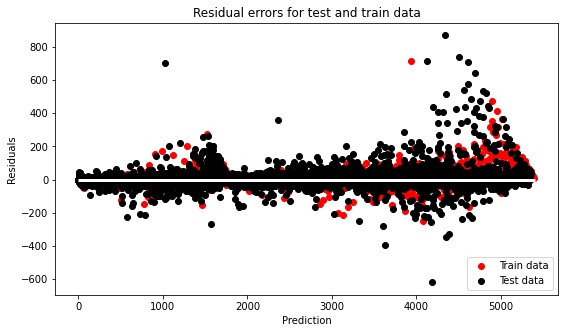

In [181]:
# This model has the least residual sum square, lets plot residuals vs prediction
# heteroscedasticity
plt.figure(figsize=(9,5))
plt.scatter(y_pred_rf_train, (y_train_ens - y_pred_rf_train), color = 'red', label = 'Train data')
plt.scatter(y_pred_rf_test, (y_test_ens - y_pred_rf_test), color = 'black', label = 'Test data')
plt.hlines(xmin = 0, xmax = 5400, y = 0, linewidth = 3, color= "white")
plt.title('Residual errors for test and train data')
plt.xlabel('Prediction')
plt.ylabel('Residuals')
plt.legend(loc = 4)
plt.show()

Its heteroscedasticity because the variance is not constant, since it is a 1.4 millions of data and if we consider denser part, we can vistualize similar variance

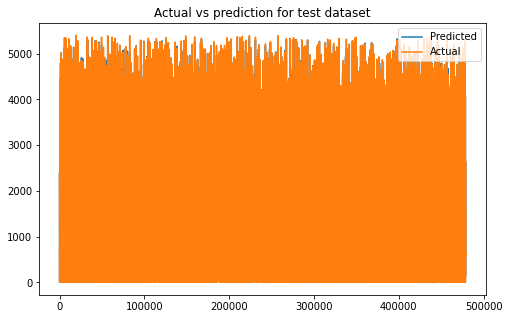

In [126]:
plt.figure(figsize=(8,5))
plt.plot(y_pred_rf_test)
plt.plot(np.array(y_test_ens))
plt.legend(["Predicted","Actual"])
plt.title("Actual vs prediction for test dataset")
plt.show()

As we can observe that our training MSE is 6.8402 and testing MSE is 40.7097, which is'nt big fluctuation we cannot say if its overfitting(since testing error is higher than training error) , but our model's R2 score for both test and train is about 0.999983 which means 99.99% of variance in Y is predictable by our independent variables which is a good score.

We can see in the above graph that almost every actual values is captured by our predition model

# XGboost Regrressor

In [116]:
regressor_xgb = XGBRegressor(n_jobs=-1)
regressor_xgb.fit(X_train_ens,y_train_ens)

[19:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_jobs=-1)

In [137]:
y_test_pred_xgb = regressor_xgb.predict(X_test_ens)
y_train_pred_xgb = regressor_xgb.predict(X_train_ens)

In [139]:
regressor_xgb.score(X_test_ens, y_test_ens)

0.9937987014264625

In [142]:
xgb_test_mse  = mean_squared_error(y_test_ens, y_test_pred_xgb)
print("MSE of XGboost_regressor for test split :" , xgb_test_mse)

xgb_test_rmse = np.sqrt(rf_test_mse)
print("RMSE of XGboost_regressor for test split :" ,xgb_test_rmse)

xgb_test_r2 = r2_score(y_test_ens, y_test_pred_xgb)
print("R2 of XGboost_regressor for test split :" ,xgb_test_r2)

n_test = X_test_ens.shape[0]
k_test = X_test_ens.shape[1]
xgb_test_adjusted_r2 = 1-(1-xgb_test_r2)*((n_test-1)/(n_test- k_test -1))
print("Adjusted R2 of XGboost_regressor for test split : " ,xgb_test_adjusted_r2)

xgb_test_rss = sum((y_test_ens - y_test_pred_xgb)**2)
print("Residual Sum Square of XGboost_regressor for test split : ",xgb_test_rss)

MSE of XGboost_regressor for test split : 2534.4472544124937
RMSE of XGboost_regressor for test split : 6.380418566287831
R2 of XGboost_regressor for test split : 0.9937987014264625
Adjusted R2 of XGboost_regressor for test split :  0.9937984811440926
Residual Sum Square of XGboost_regressor for test split :  1212973783.7252643


In [143]:
xgb_train_mse  = mean_squared_error(y_train_ens, y_train_pred_xgb)
print("MSE of XGboost_regressor for train split :" , xgb_train_mse)

xgb_train_rmse = np.sqrt(rf_train_mse)
print("RMSE of XGboost_regressor for train split :" ,xgb_train_rmse)

xgb_train_r2 = r2_score(y_train_ens, y_train_pred_xgb)
print("R2 of XGboost_regressor for train split :" ,xgb_train_r2)

n_train = X_train_ens.shape[0]
k_train = X_train_ens.shape[1]
xgb_train_adjusted_r2 = 1-(1-xgb_train_r2)*((n_train-1)/(n_test- k_train -1))
print("Adjusted R2 of XGboost_regressor for train split : " ,xgb_train_adjusted_r2)

xgb_train_rss = sum((y_train_ens - y_train_pred_xgb)**2)
print("Residual Sum Square of XGboost_regressor for train split : ",rf_train_rss)

MSE of XGboost_regressor for train split : 2458.211376918511
RMSE of XGboost_regressor for train split : 2.6153792520669397
R2 of XGboost_regressor for train split : 0.9940437871437788
Adjusted R2 of XGboost_regressor for train split :  0.9879066639845593
Residual Sum Square of XGboost_regressor for train split :  6646569.16599498


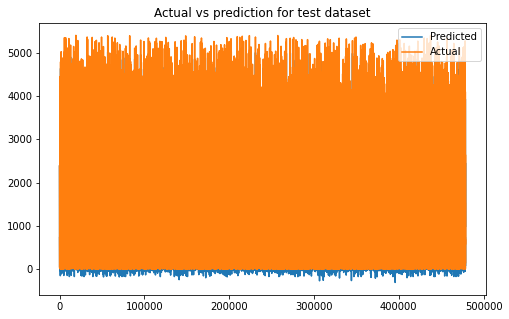

In [148]:
plt.figure(figsize=(8,5))
plt.plot(y_test_pred_xgb)
plt.plot(np.array(y_test_ens))
plt.legend(["Predicted","Actual"])
plt.title("Actual vs prediction for test dataset")
plt.show()

In [145]:
features = X_train_ens.columns
importances = regressor_xgb.feature_importances_
indices = np.argsort(importances)

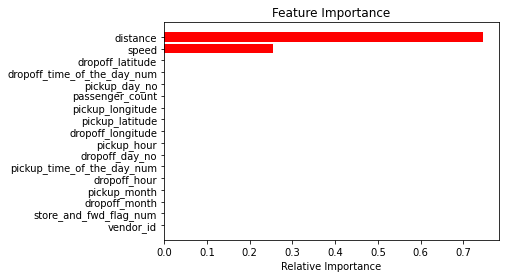

In [147]:
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()